In [2]:
import sys
sys.path.append("/nfs/gatsbystor/nicholasg/striatal_replay/scripts")
from kalman_filter import KalmanFilter
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d

In [3]:
def findIndicesOfValidSeqs(behavioral_data, correct_seq=[2, 1, 6, 3, 7]):
    valid_seqs_indices = []
    reward_times_indices = \
        np.where(np.logical_not(np.isnan(behavioral_data["Reward_Times"])))[0]
    for reward_index in reward_times_indices:
        seq_index = 4
        prev_index = 0
        append_seq_indices = True
        valid_seq_indices = []
        while seq_index >= 0:
            while behavioral_data.loc[reward_index-prev_index, "Port"] == \
                    correct_seq[seq_index]:
                valid_seq_indices.append(reward_index-prev_index)
                prev_index += 1
            seq_index -= 1
            if seq_index >= 0:
                if behavioral_data.loc[reward_index-prev_index, "Port"] != \
                    correct_seq[seq_index]:
                        append_seq_indices = False
        if append_seq_indices:
            valid_seqs_indices += valid_seq_indices
    valid_seqs_indices.sort()
    return valid_seqs_indices

def colored_line(x, y, c, ax, **lc_kwargs):
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)
    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)
    return ax.add_collection(lc)

def filter_df_on_likelihood(df, threshold = 0.98, interpolate_between=True):
    df = df.copy()
    df.columns = df.columns.droplevel((0,1))
    if not interpolate_between:
        df = df[df["likelihood"] >= threshold]
    else:
        df.loc[df["likelihood"] < threshold] = pd.NA
        if df.iloc[0].isna().all():
            first_vals = df.isna().values.argmin(axis=0)
            for i, val in enumerate(first_vals):
                df.iloc[[0, i]] = df.iloc[[val, i]].copy()
        if df.iloc[-1].isna().all():
            last_vals = len(df) - df.isna().values[::-1].argmin(axis=0) - 1
            for i, val in enumerate(last_vals):
                df.iloc[[-1, i]] = df.iloc[[val, i]].copy()
        df.interpolate(inplace=True)
    return df[["x", "y"]]

def extract_centre_point_using_histogram(df, bins=20):
    hist_counts, hist_edges_x, hist_edges_y = np.histogram2d(df.x, df.y, bins=bins)
    hist_centers_x = np.diff(hist_edges_x) + hist_edges_x[0]
    hist_centers_y = np.diff(hist_edges_y) + hist_edges_y[0]
    idx_x, idx_y = np.unravel_index(np.argmax(hist_counts), hist_counts.shape)
    point = (hist_centers_x[idx_x], hist_centers_y[idx_y])
    return point

def get_starts_ends_of_sequence(df1, df2, start_time_col="backcam_aligned_pokein_times", end_time_col="backcam_aligned_pokeout_times"):
    shared_idxs = df2.index[df2.index.isin(df1.index)]
    starts = df1.loc[shared_idxs][start_time_col]
    ends = df2.loc[shared_idxs][end_time_col]
    starts_ends_times_seqs = pd.concat([starts, ends], axis=1)
    starts_ends_times_seqs.columns = ("start_time", "end_time")
    return starts_ends_times_seqs

def get_tracking_idxs_from_times_df(times_df, keypoint_df, fps = 60):
    timestamps = keypoint_df.index.values / fps
    tracking_idxs = {
        "start_idx": [],
        "end_idx": []
    }
    for i, (start_time, end_time) in times_df.iterrows():
        tracking_idxs["start_idx"].append(np.abs(timestamps - start_time).argmin())
        tracking_idxs["end_idx"].append(np.abs(timestamps - end_time).argmin())
    return pd.DataFrame(tracking_idxs, index=times_df.index)

def get_camera_sync_times(keypoint_df, sync_df, fps = 60):
    first_pokes = sync_df["FirstPoke_EphysTime"].values
    mask = ~np.isnan(first_pokes)
    ephys_times = first_pokes[mask]
    camera_times = sync_df["backcam_aligned_P1In_times"].values[mask]
    camera_frames = np.round(camera_times * fps)
    frame_to_ephys_interpolation = interp1d(camera_frames,ephys_times,fill_value='extrapolate')
    frame_to_camera_interpolation = interp1d(camera_frames,camera_times,fill_value='extrapolate')
    camera_frames_from_movement = keypoint_df.iloc[:,0].index.values
    camera_frames_in_ephys_time = frame_to_ephys_interpolation(camera_frames_from_movement)
    camera_frames_in_camera_time = frame_to_camera_interpolation(camera_frames_from_movement)
    return pd.DataFrame({
        "ephys_time": camera_frames_in_ephys_time,
        "camera_time": camera_frames_in_camera_time
    })

def get_camera_times_from_times_df(times_df, camera_times_df, camera_times_col = "camera_time"):
    tracking_idxs = {
        "start_idx": [],
        "end_idx": []
    }
    for i, (start_time, end_time) in times_df.iterrows():
        tracking_idxs["start_idx"].append((camera_times_df[camera_times_col] - start_time).abs().argmin())
        tracking_idxs["end_idx"].append((camera_times_df[camera_times_col] - end_time).abs().argmin())
    return pd.DataFrame(tracking_idxs, index = times_df.index)


def interpolate_x_y_data(df, t = np.arange(0, 1, 1000)):
    p = np.linspace(0, 1, len(df))
    x_interp = np.interp(t, p, df.x)
    y_interp = np.interp(t, p, df.y)
    return x_interp, y_interp

def calculate_average_keypoint(df, keypoint_cols=["left_ear", "right_ear", "head_centre"], threshold=[0.98, 0.98, 0.98]):
    if isinstance(threshold, float):
        threshold = [threshold] * len(keypoint_cols)
    output = None
    for i, (keypoint_col, thresh) in enumerate(zip(keypoint_cols, threshold)):
        keypoint_data = df.loc[:, (slice(None), keypoint_col, ["x", "y", "likelihood"])]
        keypoint_data = filter_df_on_likelihood(keypoint_data, thresh)
        if output is None:
            output = keypoint_data
            counts = pd.DataFrame(np.ones(len(output)), index=output.index)
            counts = pd.concat([counts.T] * 2).T
            counts.columns = ("x", "y")
        else:
            new_idxs = keypoint_data[~keypoint_data.index.isin(output.index)].index
            new_counts = pd.DataFrame(np.ones(len(new_idxs)), index=new_idxs)
            new_counts = pd.concat([new_counts.T] * 2).T
            new_counts.columns = ("x", "y")
            shared_idxs = keypoint_data[keypoint_data.index.isin(output.index)].index
            counts = pd.concat([counts, new_counts]).sort_index()
            keypoint_data.loc[shared_idxs] /= counts.loc[shared_idxs]
            output.loc[shared_idxs] *= (counts.loc[shared_idxs] - 1) / counts.loc[shared_idxs]
            output.loc[shared_idxs] += keypoint_data.loc[shared_idxs]
            output = pd.concat([keypoint_data.loc[new_idxs], output]).sort_index()
    return output

In [4]:
organized_data_folder = "/ceph/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30-03-2022/"
processed_data_folder = "/nfs/gatsbystor/nicholasg/striatal_replay/processed_data"

In [5]:
back_pos_df = pd.read_hdf(os.path.join(organized_data_folder, "video", "tracking", "2_task", "back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5"), "df_with_missing")
back_pos_df

scorer    DLC_resnet50_task-tracking_backviewApr6shuffle1_800000              \
bodyparts                                               left_ear               
coords                                                         x           y   
0                                                 314.677002      613.623718   
1                                                 313.086517      614.376526   
2                                                 312.222565      613.870911   
3                                                 311.177704      612.852966   
4                                                 310.787781      611.551819   
...                                                      ...             ...   
164722                                            989.293640      857.788208   
164723                                            988.615112      857.374207   
164724                                            988.083984      856.993591   
164725                                            955.039307      866.663452   
164726                                            956.424561      867.342285   

scorer                                                                \
bodyparts               right_ear                        head_centre   
coords    likelihood            x           y likelihood           x   
0           0.999978   415.459747  584.644348   0.999604  366.061066   
1           0.999953   413.810455  585.311279   0.999321  365.491608   
2           0.999975   413.822693  586.121765   0.998607  364.315460   
3           0.999987   413.189178  586.227722   0.998934  363.241913   
4           0.999992   412.628723  586.373962   0.998626  362.535126   
...              ...          ...         ...        ...         ...   
164722      0.000330   986.457764  860.715210   0.000199  987.314392   
164723      0.000512   986.021301  860.786255   0.000290  986.755371   
164724      0.000154  1007.383057  859.719727   0.000096  972.169067   
164725      0.000064  1005.881165  860.325500   0.000041  973.527893   
164726      0.000069  1005.867676  860.115112   0.000076  973.936096   

scorer                                                                  \
bodyparts                        implant_centre                          
coords              y likelihood              x           y likelihood   
0          584.250671   0.999597     359.682373  539.862183   0.999956   
1          585.148315   0.999591     358.531738  539.472961   0.999967   
2          585.561768   0.999709     357.101898  539.707642   0.999975   
3          585.304504   0.999731     356.216064  539.854858   0.999977   
4          584.520691   0.999748     355.045410  539.468933   0.999981   
...               ...        ...            ...         ...        ...   
164722     862.659119   0.000177     989.887695  862.560730   0.996058   
164723     862.310120   0.000294     991.325806  863.018066   0.996171   
164724     875.815002   0.000203     991.324463  862.764893   0.979532   
164725     875.611389   0.000064     994.681335  864.246704   0.958143   
164726     876.193542   0.000110     995.533508  864.306396   0.971416   

scorer                                        
bodyparts   tail_base                         
coords              x           y likelihood  
0          526.411133  748.714844   0.999934  
1          526.559326  748.799683   0.999946  
2          526.644531  748.966431   0.999948  
3          526.458740  749.343933   0.999941  
4          526.424377  749.724487   0.999955  
...               ...         ...        ...  
164722     986.789673  858.737671   0.000325  
164723     986.416260  858.764221   0.000532  
164724     773.706116  956.426575   0.000122  
164725     773.701233  956.396301   0.000094  
164726     773.485901  956.369995   0.000062  

[164727 rows x 15 columns]

In [6]:
keypoint_df = calculate_average_keypoint(back_pos_df)
y = keypoint_df.values.T
kf = KalmanFilter(pos_x0=y[0,0], pos_y0=y[1,0])
means, std_devs = kf.smooth(y)
display(means.shape)
display(std_devs.shape)

ValueError: could not broadcast input array from shape (2,2) into shape (164727,164727)

In [6]:
behavioral_data = pd.read_csv(os.path.join(organized_data_folder, "behav_sync", "2_task", "Behav_Ephys_Camera_Sync.csv"), index_col=0)
display(behavioral_data.columns)
behavioral_data

Index(['Trial_id', 'Trial_Start', 'Port', 'PokeIn_Time', 'PokeOut_Time',
       'Reward_Times', 'Trial_End', 'Port_2-3-4-5_LED_intensities',
       'Port_1-2-3-4_RewardAmount', 'TrainingLevel', 'TrialStart_EphysTime',
       'FirstPoke_EphysTime', 'PokeIN_EphysTime', 'PokeOUT_EphysTime',
       'backcam_trialstart_seconds', 'backcam_aligned_pokein_times',
       'backcam_aligned_pokeout_times', 'backcam_trialstart_timestamps',
       'sidecam_trialstart_seconds', 'sidecam_aligned_pokein_times',
       'sidecam_aligned_pokeout_times', 'sidecam_trialstart_timestamps',
       'bottomcam_trialstart_seconds', 'bottomcam_aligned_pokein_times',
       'bottomcam_aligned_pokeout_times', 'bottomcam_trialstart_timestamps'],
      dtype='object')

,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,TrainingLevel,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
0,1,33.5779,7,39.1177,39.3896,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,347.811700,20520.0,342.000000,347.539800,347.811700,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
1,1,33.5779,7,39.5222,39.7818,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,348.203900,20520.0,342.000000,347.944300,348.203900,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2,1,33.5779,7,45.3722,45.9151,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,354.337200,20520.0,342.000000,353.794300,354.337200,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3,1,33.5779,1,46.7517,47.4965,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,355.918600,20520.0,342.000000,355.173800,355.918600,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
4,1,33.5779,3,49.2089,49.3717,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,357.793800,20520.0,342.000000,357.631000,357.793800,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,277,2411.2686,6,2414.8285,2415.0117,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2724.709767,163258.0,2720.966667,2724.526567,2724.709767,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2178,277,2411.2686,3,2415.3505,2415.7008,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.398867,163258.0,2720.966667,2725.048567,2725.398867,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2179,277,2411.2686,2,2415.3840,2415.5804,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.278467,163258.0,2720.966667,2725.082067,2725.278467,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2180,277,2411.2686,2,2415.5868,2415.6890,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.387067,163258.0,2720.966667,2725.284867,2725.387067,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [7]:
valid_seqs_indices = findIndicesOfValidSeqs(behavioral_data)
correct_seqs = behavioral_data.iloc[valid_seqs_indices]
correct_seqs

,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,TrainingLevel,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
17,1,33.5779,2,61.4296,61.8883,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,370.310400,20520.0,342.000000,369.851700,370.310400,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
18,1,33.5779,1,63.1067,63.4154,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,371.837500,20520.0,342.000000,371.528800,371.837500,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
19,1,33.5779,6,64.3364,64.5665,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,372.988600,20520.0,342.000000,372.758500,372.988600,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
20,1,33.5779,3,64.9775,65.1747,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,373.596800,20520.0,342.000000,373.399600,373.596800,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
21,1,33.5779,7,65.5319,66.7492,65.5319,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,375.171300,20520.0,342.000000,373.954000,375.171300,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,276,2406.9343,1,2408.3064,2408.4858,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2718.184833,162998.0,2716.633333,2718.005433,2718.184833,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2171,276,2406.9343,6,2409.0497,2409.2679,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2718.966933,162998.0,2716.633333,2718.748733,2718.966933,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2172,276,2406.9343,3,2409.6475,2409.8396,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2719.538633,162998.0,2716.633333,2719.346533,2719.538633,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2173,276,2406.9343,3,2410.0185,2410.4540,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2720.153033,162998.0,2716.633333,2719.717533,2720.153033,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [8]:
port_names = back_ports_df.columns.get_level_values(1).unique()
port_points = np.zeros((2, len(port_names)))

for i, port_name in enumerate(port_names):
    port_data = back_ports_df.loc[:, (slice(None), port_name, ["x", "y", "likelihood"])]
    port_data = filter_df_on_likelihood(port_data, 0.999)
    port_point = extract_centre_point_using_histogram(port_data)
    port_points[:,i] = port_point

track_segment_lengths = np.sqrt(np.diff(port_points[0])**2 + np.diff(port_points[1])**2)
track_segment_vecs = np.diff(port_points, axis=1)
cumulative_track_segment_length = np.cumsum(track_segment_lengths)
cumulative_track_segment_length = np.insert(cumulative_track_segment_length, 0, 0)

keypoint_df = calculate_average_keypoint(back_pos_df, keypoint_cols=["head_centre"])
sync_file = os.path.join(organized_data_folder,"behav_sync", "2_task", "Transition_data_sync.csv")
sync_df = pd.read_csv(sync_file)
camera_sync_times = get_camera_sync_times(keypoint_df, sync_df)

all_trajectories = {
    "trial_id": [],
    "camera_idx": [],
    "camera_time": [],
    "ephys_time": [],
    "linear_position": [],
    "x_position": [],
    "y_position": [],
    "port1": [],
    "port2": []
}

for i, (port1_name, port2_name) in enumerate(zip(port_names[:-1], port_names[1:])):

    port1 = int(port1_name[-1])
    port2 = int(port2_name[-1])
    port1_df = correct_seqs[correct_seqs["Port"] == port1].groupby("Trial_id").agg("last")
    port2_df = correct_seqs[correct_seqs["Port"] == port2].groupby("Trial_id").agg("first")

    start_time_col="backcam_aligned_pokein_times"
    end_time_col="backcam_aligned_pokein_times"

    starts_ends_times_seqs = get_starts_ends_of_sequence(port1_df, 
                                                     port2_df,
                                                     start_time_col,
                                                     end_time_col)
    
    # tracking_idxs_df = get_tracking_idxs_from_times_df(starts_ends_times_seqs, keypoint_df)
    tracking_idxs_df = get_camera_times_from_times_df(starts_ends_times_seqs, camera_sync_times)

    linear_offset = cumulative_track_segment_length[i]
    track_segment_vec = track_segment_vecs[:,i]
    track_segment_point = port_points[:,i]
    track_segment_length = track_segment_lengths[i]

    for j, (start_idx, end_idx) in tracking_idxs_df.iterrows():

        trial_id = port1_df.loc[j].name

        trajectory = keypoint_df.iloc[start_idx:end_idx]
        trajectory_start = trajectory.iloc[0]
        trajectory_end = trajectory.iloc[-1]
        segment_vec = trajectory_end - trajectory_start
        
        magnitude = np.dot(segment_vec, segment_vec)
        projection = np.dot((trajectory - trajectory_start), segment_vec) / magnitude
        linear_trajectory = projection * np.linalg.norm(track_segment_vec) + linear_offset

        for k, pos in enumerate(linear_trajectory):
            all_trajectories["trial_id"].append(trial_id)
            all_trajectories["camera_idx"].append(start_idx + k)
            all_trajectories["camera_time"].append(camera_sync_times.iloc[start_idx + k]["camera_time"])
            all_trajectories["ephys_time"].append(camera_sync_times.iloc[start_idx + k]["ephys_time"])
            all_trajectories["linear_position"].append(linear_trajectory[k])
            all_trajectories["x_position"].append(trajectory["x"].iloc[k])
            all_trajectories["y_position"].append(trajectory["y"].iloc[k])
            all_trajectories["port1"].append(port1)
            all_trajectories["port2"].append(port2)

all_trajectories = pd.DataFrame(all_trajectories, index=all_trajectories["camera_idx"]).sort_index()
all_trajectories

,trial_id,camera_idx,camera_time,ephys_time,linear_position,x_position,y_position,port1,port2
22191,1,22191,369.857173,4800.884355,0.000000,670.492310,513.852478,2,1
22192,1,22192,369.873841,4800.901010,-0.607927,671.156128,512.822449,2,1
22193,1,22193,369.890509,4800.917665,-0.010407,670.305847,513.338928,2,1
22194,1,22194,369.907178,4800.934320,0.082560,670.071716,513.164001,2,1
22195,1,22195,369.923846,4800.950974,0.010824,670.314087,513.453674,2,1
...,...,...,...,...,...,...,...,...,...
163228,276,163228,2720.473922,7150.310765,597.237558,650.354614,576.198364,3,7
163229,276,163229,2720.490593,7150.327440,606.095453,654.041809,570.472900,3,7
163230,276,163230,2720.507265,7150.344115,616.064659,655.980164,564.733582,3,7
163231,276,163231,2720.523936,7150.360789,627.483287,657.201050,558.478149,3,7


In [10]:
all_trajectories.to_csv(os.path.join(processed_data_folder, "all_trajectories.csv"))

In [13]:
all_trajectories = pd.read_csv(os.path.join(processed_data_folder, "all_trajectories.csv"), index_col=0)
all_trajectories

,trial_id,camera_idx,camera_time,ephys_time,linear_position,x_position,y_position,port1,port2
22191,1,22191,369.857173,4800.884355,0.000000,670.492310,513.852478,2,1
22192,1,22192,369.873841,4800.901010,-0.607927,671.156128,512.822449,2,1
22193,1,22193,369.890509,4800.917665,-0.010407,670.305847,513.338928,2,1
22194,1,22194,369.907178,4800.934320,0.082560,670.071716,513.164001,2,1
22195,1,22195,369.923846,4800.950974,0.010824,670.314087,513.453674,2,1
...,...,...,...,...,...,...,...,...,...
163228,276,163228,2720.473922,7150.310765,597.237558,650.354614,576.198364,3,7
163229,276,163229,2720.490593,7150.327440,606.095453,654.041809,570.472900,3,7
163230,276,163230,2720.507265,7150.344115,616.064659,655.980164,564.733582,3,7
163231,276,163231,2720.523936,7150.360789,627.483287,657.201050,558.478149,3,7


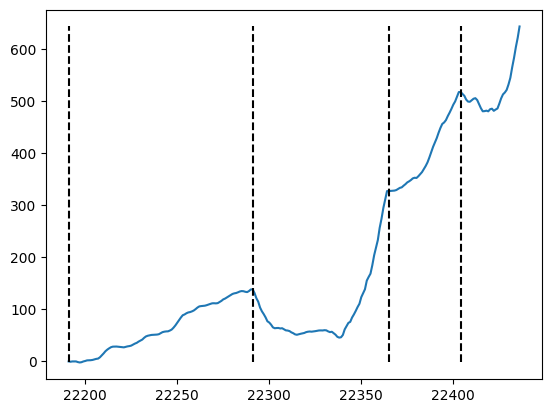

In [14]:
trial_id = 1
plt.plot(all_trajectories[all_trajectories["trial_id"] == trial_id]["linear_position"])
grouped_trial_df = all_trajectories.groupby(["trial_id", "port1"]).agg("first").sort_values(["trial_id", "camera_idx"])
trial_df = grouped_trial_df.loc[trial_id]
min_val = all_trajectories[all_trajectories["trial_id"] == trial_id]["linear_position"].min()
max_val = all_trajectories[all_trajectories["trial_id"] == trial_id]["linear_position"].max()
plt.vlines(trial_df.camera_idx.values, min_val, max_val, color="black", ls="--")

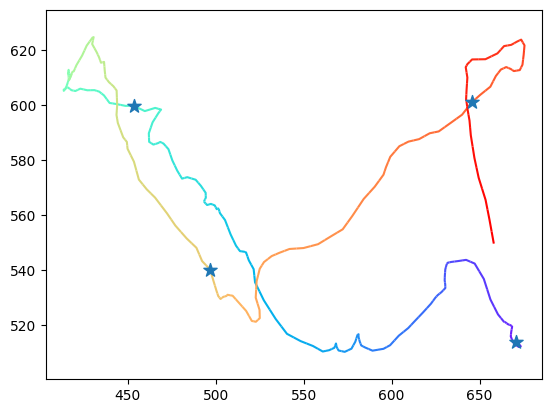

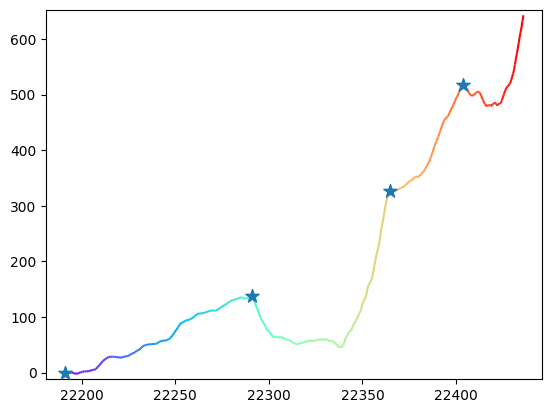

In [15]:
trial_id = 1
trial_df = all_trajectories[all_trajectories["trial_id"] == trial_id]
grouped_trial_df = all_trajectories.groupby(["trial_id", "port1"]).agg("first").sort_values(["trial_id", "camera_idx"])
segmented_df = grouped_trial_df.loc[trial_id]

fig, ax = plt.subplots()
x_pos = trial_df["x_position"].values
y_pos = trial_df["y_position"].values
lines = colored_line(x_pos, y_pos, np.arange(len(x_pos)), ax, cmap="rainbow")
padding = 10
ax.set_xlim([np.min(x_pos) - padding, np.max(x_pos) + padding])
ax.set_ylim([np.min(y_pos) - padding, np.max(y_pos) + padding])
sub_x = trial_df.loc[segmented_df.camera_idx.values]["x_position"]
sub_y = trial_df.loc[segmented_df.camera_idx.values]["y_position"]
ax.scatter(sub_x, sub_y, marker = "*", s=100, zorder=3)
plt.show()

fig, ax = plt.subplots()
x_pos = trial_df.index.values
y_pos = trial_df["linear_position"].values
lines = colored_line(x_pos, y_pos, np.arange(len(x_pos)), ax, cmap="rainbow")
padding = 10
ax.set_xlim([np.min(x_pos) - padding, np.max(x_pos) + padding])
ax.set_ylim([np.min(y_pos) - padding, np.max(y_pos) + padding])
sub_x = segmented_df.camera_idx.values
sub_y = trial_df.loc[segmented_df.camera_idx.values]["linear_position"]
ax.scatter(sub_x, sub_y, marker = "*", s=100, zorder=3)
plt.show()

In [16]:
Fs = 30000.0
cutoff = 1_000_000

session_data = Session(str(open_ephys_folder))
recording = session_data.recordnodes[0].recordings[0]
recording.add_sync_line(1, 102, '0', main=True)
recording.compute_global_timestamps()
ephys_timestamps = recording.continuous[2].global_timestamps

spike_times = (np.load(os.path.join(organized_data_folder, "ephys", "kilosort3", "spike_times.npy")).squeeze() / Fs) + ephys_timestamps[0]
spike_clusters = np.load(os.path.join(organized_data_folder, "ephys", "kilosort3", "spike_clusters.npy")).squeeze()

unique_clusters = np.unique(spike_clusters)
clusters_count = len(unique_clusters)
clusters_mapping = np.arange(np.max(spike_clusters)+1)
clusters_mapping[unique_clusters] = np.arange(clusters_count)
spikes = np.zeros((clusters_count, cutoff), dtype=int)
spikes[clusters_mapping[spike_clusters][:cutoff], np.arange(spikes.shape[1])] = 1

trial_start_times = all_trajectories.groupby(["trial_id"]).agg("first")["ephys_time"]
trial_start_times.name = "start_time"
trial_end_times = all_trajectories.groupby(["trial_id"]).agg("last")["ephys_time"]
trial_end_times.name = "end_time"

trial_ephys_times = pd.concat([trial_start_times, trial_end_times], axis=1)

all_spike_times = np.array([])
for i, (trial_time) in trial_ephys_times.iterrows():
    start = trial_time["start_time"]
    end = trial_time["end_time"]
    mask_start = (spike_times >= start).argmax()
    mask_end = (spike_times >= end).argmax()
    all_spike_times = np.append(all_spike_times, spike_times[mask_start:mask_end])
    if len(all_spike_times) > cutoff:
        all_spike_times = all_spike_times[:cutoff]
        break

position = np.array([])
for i, spike_time in enumerate(all_spike_times):
    print(f"{(i+1)/len(all_spike_times)*100:.2f}%", end="\r")
    idx = (all_trajectories["ephys_time"] - spike_time).abs().argmin()
    position = np.append(position, all_trajectories.iloc[idx]["linear_position"])


Processor ID: 102, Stream Name: 0, Line: 1 (main sync line))
  First event sample number: 60920380
  Last event sample number: 512017786
  Total sync events: 15036
  Sample rate: 30000


In [17]:
np.save(os.path.join(processed_data_folder, "spikes.npy"), spikes)
np.save(os.path.join(processed_data_folder, "position.npy"), position)

In [18]:
spikes = np.load(os.path.join(processed_data_folder, "spikes.npy"))
position = np.load(os.path.join(processed_data_folder, "position.npy"))
display(spikes)
display(position)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

array([   0.        ,    0.        ,    0.        , ..., -265.65648489,
       -265.65648489, -265.65648489])

In [14]:
movement_var = estimate_movement_var(position, Fs)

decoder = SortedSpikesDecoder(movement_var=movement_var,
                                 replay_speed=1,
                                 spike_model_penalty=0.5,
                                 place_bin_size=np.sqrt(movement_var))

decoder.fit(position, spikes)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [13]:
trial_start_times = all_trajectories.groupby(["trial_id"]).agg("first")["ephys_time"]
trial_start_times.name = "start_time"
trial_end_times = all_trajectories.groupby(["trial_id"]).agg("last")["ephys_time"]
trial_end_times.name = "end_time"

trial_ephys_times = pd.concat([trial_start_times, trial_end_times], axis=1)

# get_camera_times_from_times_df(trial_ephys_times, )
all_spike_times = np.array([])

for i, (trial_time) in trial_ephys_times.iterrows():
    start = trial_time["start_time"]
    end = trial_time["end_time"]
    mask_start = (spike_times >= start).argmax()
    mask_end = (spike_times >= end).argmax()
    # spikes = np.zeros((clusters_count, mask_end-mask_start), dtype=int)
    # for spike_time in spike_times[mask_start:mask_end]:
    #     # position = all_trajectories[all_trajectories["ephys_time"] - spike_time]
    #     get_camera_times_from_times_df()
    #     display((all_trajectories["ephys_time"] - spike_time).abs())
    #     raise
    all_spike_times = np.append(all_spike_times, spike_times[mask_start:mask_end])

position_times = get_camera_times_from_times_df(trial_ephys_times, all_trajectories, camera_times_col="ephys_time")

In [15]:
position = []
for i, spike_time in enumerate(all_spike_times):
    print(f"{(i+1)/len(all_spike_times)*100:.2f}%", end="\r")
    idx = (all_trajectories["ephys_time"] - spike_time).abs().argmin()
    position.append(all_trajectories.iloc[idx]["linear_position"])
position = np.array(position)
# position_times

In [18]:
trajectories_ephys_time = all_trajectories["ephys_time"].values
time_diff = np.abs(trajectories_ephys_time - all_spike_times[:,np.newaxis])
position_idx = np.argmin(time_diff, axis=0)

: 

In [15]:
time_diff.shape

(1000000,)

In [35]:
open_ephys_folder = "/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/"
session_data = Session(str(open_ephys_folder))
recording = session_data.recordnodes[0].recordings[0]
recording.add_sync_line(1, 102, '0', main=True)
recording.compute_global_timestamps()

Processor ID: 102, Stream Name: 0, Line: 1 (main sync line))
  First event sample number: 60920380
  Last event sample number: 512017786
  Total sync events: 15036
  Sample rate: 30000


In [36]:
ephys_timestamps = recording.continuous[2].global_timestamps

In [37]:
# spikes = np.array([])
# keypoint_df = calculate_average_keypoint(back_pos_df, keypoint_cols=["head_centre"])
start_ephys_times = all_trajectories.groupby(["trial_id"]).agg("first")["ephys_time"]
end_ephys_times = all_trajectories.groupby(["trial_id"]).agg("last")["ephys_time"]
ephys_idxs = np.ravel([np.where(np.logical_and(ephys_timestamps > start, ephys_timestamps < end))[0] for start, end in zip(start_ephys_times, end_ephys_times)])

KeyboardInterrupt: 

In [56]:
ephys_timestamps_mask = np.zeros_like(ephys_timestamps)
for i, (start, end) in enumerate(zip(start_ephys_times.iloc[1:], end_ephys_times.iloc[1:])):
    print(f"Processing chunk: {i+1}", end="\r")
    mask_start = (ephys_timestamps >= start).argmax()
    mask_end = (ephys_timestamps >= end).argmax()
    ephys_timestamps_mask[mask_start:mask_end] = 1

In [66]:
cutoff = 1_000_000
unique_clusters = np.unique(spike_clusters)
clusters_count = len(unique_clusters)
clusters_mapping = np.arange(np.max(spike_clusters)+1)
clusters_mapping[unique_clusters] = np.arange(clusters_count)
spikes = np.zeros((clusters_count, cutoff), dtype=int)
spikes[clusters_mapping[spike_clusters][:cutoff], np.arange(spikes.shape[1])] = 1
position = spike_times

In [68]:
spikes[clusters_mapping[spike_clusters][:cutoff], np.arange(spikes.shape[1])] = 1